# 1. Setup

## 1.1 Install Dependencies

In [2]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-2.9.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)
  Using cached tensorflow_gpu-2.9.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 9.0 MB/s eta 0:00:000m eta 0:00:010:00:01
  Using cached matplotlib-3.5.2-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached libclang-14.0.1-py2.py3-none-manylinux1_x86_64.whl (14.5 MB)
  Using cached tensorflow_io_gcs_filesystem-0.26.0-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Preparing metadata (setup.py) ... done
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached wrapt-1.14.1-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (77 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using ca

## 1.2 Import Dependencies

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [7]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [Errno 17] File exists: 'data/positive'

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [8]:
# http://vis-www.cs.umass.edu/lfw/

In [9]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [10]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [5]:
# Import uuid library to generate unique image names
import uuid

In [31]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/1136f6b4-0350-11ed-88da-fcaa149d3f2f.jpg'

In [32]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(4)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

[ WARN:0@2928.664] global /io/opencv/modules/videoio/src/cap_v4l.cpp (902) open VIDEOIO(V4L2:/dev/video4): can't open camera by index


In [33]:
plt.imshow(frame[120:120+250,200:200+250, :])

NameError: name 'frame' is not defined

# 2.x NEW - Data Augmentation

In [9]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [11]:
import os
import uuid

In [12]:
img_path = os.path.join(ANC_PATH, '924e839c-135f-11ec-b54e-a0cec8d2d278.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [6]:
anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, '*.jpg')).take(300)
positive = tf.data.Dataset.list_files(os.path.join(POS_PATH, '*.jpg')).take(300)
negative = tf.data.Dataset.list_files(os.path.join(NEG_PATH, '*.jpg')).take(300)

2022-07-15 11:33:26.470003: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-15 11:33:27.039937: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:06:00.0, compute capability: 8.6


In [7]:
dir_test = anchor.as_numpy_iterator()

In [8]:
print(dir_test.next())

b'data/anchor/174a04ad-2d60-11ec-80fb-d8f2ca9251bb.jpg'


## 3.2 Preprocessing - Scale and Resize

In [9]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [10]:
img = preprocess('data/anchor/19271bf3-2d60-11ec-afdd-d8f2ca9251bb.jpg')

In [11]:
img.numpy().max() 

1.0

## 3.3 Create Labelled Dataset

In [12]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [13]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [14]:
samples = data.as_numpy_iterator()

In [15]:
exampple = samples.next()

In [16]:
exampple

(b'data/anchor/124084fc-2d60-11ec-b4a7-d8f2ca9251bb.jpg',
 b'data/positive/3c05fa84-2d60-11ec-8e11-d8f2ca9251bb.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [17]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [18]:
res = preprocess_twin(*exampple)

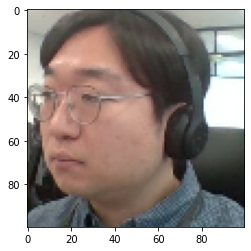

In [19]:
plt.imshow(res[0])

In [20]:
res[2]

1.0

In [21]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [22]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [23]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [85]:
inp = Input(shape=(100,100,3), name='input_image')

In [86]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [89]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [90]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [91]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [92]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [96]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 17, 128)       26

In [24]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [25]:
embedding = make_embedding()

In [26]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [27]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [28]:
l1 = L1Dist()

In [141]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

## 4.3 Make Siamese Model

In [29]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [205]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [206]:
siamese_layer = L1Dist()

In [207]:
distances = siamese_layer(inp_embedding, val_embedding)

In [208]:
classifier = Dense(1, activation='sigmoid')(distances)

In [209]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_6')>

In [210]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [211]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_4 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [30]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [31]:
siamese_model = make_siamese_model()

In [32]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

## 5.1 Setup Loss and Optimizer

In [462]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [463]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [464]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [465]:
test_batch = train_data.as_numpy_iterator()

In [466]:
batch_1 = test_batch.next()

In [467]:
X = batch_1[:2]

In [468]:
y = batch_1[2]

In [469]:
y

array([0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1.],
      dtype=float32)

In [56]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
class BinaryCrossentropy(LossFunctionWrapper):
  """Computes the cross-entropy loss between true labels and predicted labels.

  Use this cross-entropy loss when there are only two label classes (assumed to
  be 0 and 1). For each example, there should be a single floating-point value
  per prediction.

  In the snippet below, each of the four examples has only a single
  floating-pointing value, and both `y_pred` and `y_true` have the shape
  `[batch_size]`.

  Standalone usage:

  >>> y_true = [[0., 1.], [0., 0.]]
  >>> y_pred = [[0.6, 0.4], [0.4, 0.6]]
  >>> # Using 'auto'/'sum_over_batch_size' reduction type.
  >>> bce = tf.keras.losses.BinaryCrossentropy()
  >>> bce(y_true, y_pred).numpy()
  0.815

  >>> # Calling with 'sample_weight'.
  >>> bce(y_true, y_pred, sample_weight=[1, 0]).numpy()
  0.458

   >>> # Using 'sum'

In [46]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [47]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [48]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [49]:
EPOCHS = 50

In [50]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)


2022-07-15 10:33:26.067903: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-07-15 10:33:27.248271: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-15 10:33:27.410183: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


27/27 [==============================] - 6s 106ms/step
0.041306343 0.82790697 0.9368421

 Epoch 2/50
27/27 [==============================] - 2s 91ms/step
0.0064437194 0.9705882 0.99497485

 Epoch 3/50
27/27 [==============================] - 2s 90ms/step
0.19078565 1.0 1.0

 Epoch 4/50
27/27 [==============================] - 2s 91ms/step
0.028207792 0.9951923 1.0

 Epoch 5/50
27/27 [==============================] - 2s 90ms/step
0.0022519461 1.0 1.0

 Epoch 6/50
27/27 [==============================] - 2s 90ms/step
0.011101308 1.0 1.0

 Epoch 7/50
27/27 [==============================] - 2s 89ms/step
0.0038693543 0.46305418 0.94

 Epoch 8/50
27/27 [==============================] - 2s 88ms/step
0.3506234 0.8773585 1.0

 Epoch 9/50
27/27 [==============================] - 2s 89ms/step
0.119537845 0.9326923 1.0

 Epoch 10/50
27/27 [==============================] - 2s 90ms/step
0.14674152 1.0 1.0

 Epoch 11/50
1/1 [==============================] - 0s 26ms/step


27/27 [==============================] - 2s 90ms/step
0.00036217054 0.99497485 1.0

 Epoch 12/50
27/27 [==============================] - 2s 90ms/step
0.026357902 1.0 1.0

 Epoch 13/50
27/27 [==============================] - 3s 96ms/step
0.008350612 1.0 1.0

 Epoch 14/50
27/27 [==============================] - 2s 90ms/step
0.00012962 1.0 1.0

 Epoch 15/50
27/27 [==============================] - 2s 90ms/step
2.050483e-05 1.0 1.0

 Epoch 16/50
27/27 [==============================] - 2s 91ms/step
1.8239369e-05 1.0 1.0

 Epoch 17/50
27/27 [==============================] - 2s 90ms/step
1.8626521e-06 1.0 1.0

 Epoch 18/50
27/27 [==============================] - 2s 91ms/step
5.960465e-08 1.0 1.0

 Epoch 19/50
27/27 [==============================] - 2s 90ms/step
2.220371e-05 1.0 1.0

 Epoch 20/50
27/27 [==============================] - 2s 91ms/step
4.9788992e-05 1.0 1.0

 Epoch 21/50
27/27 [==============================] - 2s 90ms/step
0.0014852199 1.0 1.0

 Epoch 22/50
1/1 [=========

27/27 [==============================] - 2s 91ms/step
3.9339243e-06 1.0 1.0

 Epoch 23/50
27/27 [==============================] - 2s 90ms/step
0.00027959532 1.0 1.0

 Epoch 24/50
27/27 [==============================] - 2s 89ms/step
0.0004970564 1.0 1.0

 Epoch 25/50
27/27 [==============================] - 2s 89ms/step
2.612244e-05 1.0 1.0

 Epoch 26/50
27/27 [==============================] - 2s 90ms/step
2.980234e-07 1.0 1.0

 Epoch 27/50
27/27 [==============================] - 2s 90ms/step
4.806045e-05 1.0 1.0

 Epoch 28/50
27/27 [==============================] - 2s 90ms/step
0.00071172614 1.0 1.0

 Epoch 29/50
27/27 [==============================] - 2s 90ms/step
8.940698e-08 1.0 1.0

 Epoch 30/50
27/27 [==============================] - 2s 90ms/step
0.0022675085 1.0 1.0

 Epoch 31/50
27/27 [==============================] - 2s 90ms/step
0.0004666674 1.0 1.0

 Epoch 32/50
27/27 [==============================] - 2s 90ms/step
7.3165293e-06 1.0 1.0

 Epoch 33/50
1/1 [============

27/27 [==============================] - 2s 90ms/step
4.9770374e-06 1.0 1.0

 Epoch 34/50
27/27 [==============================] - 2s 90ms/step
1.2397999e-05 1.0 1.0

 Epoch 35/50
27/27 [==============================] - 2s 90ms/step
0.00015147148 1.0 1.0

 Epoch 36/50
27/27 [==============================] - 2s 90ms/step
1.4901161e-08 1.0 1.0

 Epoch 37/50
27/27 [==============================] - 2s 91ms/step
0.00023110458 1.0 1.0

 Epoch 38/50
27/27 [==============================] - 3s 98ms/step
-0.0 1.0 1.0

 Epoch 39/50
27/27 [==============================] - 2s 92ms/step
3.3052962e-05 1.0 1.0

 Epoch 40/50
27/27 [==============================] - 2s 92ms/step
2.980234e-07 1.0 1.0

 Epoch 41/50
27/27 [==============================] - 2s 90ms/step
3.3080796e-06 1.0 1.0

 Epoch 42/50
27/27 [==============================] - 2s 90ms/step
0.00050035986 1.0 1.0

 Epoch 43/50
27/27 [==============================] - 2s 92ms/step
0.0005295861 1.0 1.0

 Epoch 44/50
1/1 [================

27/27 [==============================] - 3s 93ms/step
-0.0 1.0 1.0

 Epoch 45/50
27/27 [==============================] - 3s 94ms/step
5.066398e-07 1.0 1.0

 Epoch 46/50
27/27 [==============================] - 2s 92ms/step
9.536761e-07 1.0 1.0

 Epoch 47/50
27/27 [==============================] - 2s 92ms/step
0.0010162195 1.0 1.0

 Epoch 48/50
27/27 [==============================] - 3s 92ms/step
-0.0 1.0 1.0

 Epoch 49/50
27/27 [==============================] - 3s 93ms/step
-0.0 1.0 1.0

 Epoch 50/50
27/27 [==============================] - 2s 92ms/step
2.5094814e-05 1.0 1.0


# 6. Evaluate Model

## 6.1 Import Metrics

In [470]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [471]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [475]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 116ms/step


In [476]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]

In [477]:
y_true

array([1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [478]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.9

In [479]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.6923077

In [480]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 19ms/step
0.90909094 0.52287585


## 6.4 Viz Results

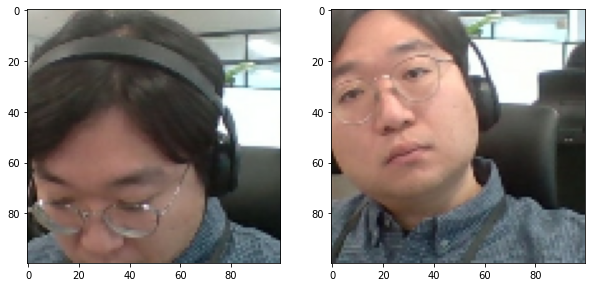

In [481]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [60]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [61]:
L1Dist

__main__.L1Dist

In [62]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [63]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 115ms/step


array([[9.9964130e-01],
       [2.4105373e-09],
       [2.7625058e-11],
       [9.9830806e-01]], dtype=float32)

In [64]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8. Real Time Test

## 8.1 Verification Function

In [ ]:
application_data\verification_images

In [ ]:
os.listdir(os.path.join('application_data', 'verification_images'))

In [ ]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

In [ ]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

In [7]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [16]:
cap = cv2.VideoCapture(4)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True


In [17]:
np.sum(np.squeeze(results) > 0.9)

36

In [18]:
results

[array([[0.9944859]], dtype=float32),
 array([[0.9999912]], dtype=float32),
 array([[0.9999943]], dtype=float32),
 array([[0.9999951]], dtype=float32),
 array([[0.99993753]], dtype=float32),
 array([[0.9082498]], dtype=float32),
 array([[0.9999846]], dtype=float32),
 array([[0.9834683]], dtype=float32),
 array([[0.87159216]], dtype=float32),
 array([[0.7328309]], dtype=float32),
 array([[0.74533516]], dtype=float32),
 array([[0.949607]], dtype=float32),
 array([[0.7501703]], dtype=float32),
 array([[0.60669833]], dtype=float32),
 array([[0.93921214]], dtype=float32),
 array([[0.9813106]], dtype=float32),
 array([[0.9848625]], dtype=float32),
 array([[0.89696234]], dtype=float32),
 array([[0.98896575]], dtype=float32),
 array([[0.99082947]], dtype=float32),
 array([[0.7747197]], dtype=float32),
 array([[0.99999297]], dtype=float32),
 array([[0.99986887]], dtype=float32),
 array([[0.9999764]], dtype=float32),
 array([[0.90808266]], dtype=float32),
 array([[0.8795649]], dtype=float32),
 a